**Introduction** 

How can we measure offensive production beyond assists, goals, and expected goals in hockey? 
Imagine a five-play possession that ended in a goal; the credited players would be the scoring player and up to two assisting players (last two touches). However, how are we crediting the other players who helped develop the possession? Which offensive action was the most impactful and significant to put the team in a position to score? These are the questions that our analysis answers.

We borrowed a soccer analytics concept called Expected Threat (xT), developed by Karun Singh to grade offensive production based on the field location at the start vs. the end of the play. In addition to adapting xT to hockey, we expanded it by adding time-remaining-in-period and turnover probability. We name the new metric: Net Expected Threat (nxT).

In soccer, the original xT model recognizes that at any point, a player possessing the ball has two options: to shoot (attempt to score) or to move the ball (dribble or pass). If a player chooses to shoot, the score-probability will depend on field location. If a player decides to move, there are multiple probable destinations, each with a different probability of success, depending on field location. xT generated (xTg) considers all possibilities and assesses by how much a player helped the team place the ball in a position to score, regardless of the actual outcome of the possession. To understand xT from a hockey perspective, interchange "ball" with "puck" and "dribble" with "zone-entry." One of the many benefits of this metric is the ability to divide credit. Take our five-play scoring-possession example. In that scenario, we can divide the xTg of each move action over the possession's total xTg. The result would be credit percentages to calculate which action or player had the highest impact. 

In this submission, we explain how nxT expands xT to analyze a broader range of outcomes. Then, we describe the methodology behind nxT. Finally, we utilize nxT generated (nxTg) to grade offensive players for scouting purposes.


*insert viz*

**Problem statement**

Hockey analysts utilize standard metrics such as assists and goals to grade offensive hockey players. The analytics revolution brought metrics like expected goals xG, which have become a staple in the hockey analytics community. However, there is still a need to quantify each move action's impact to create a scoring threat. Expected Threat (xT) is a partial solution, but there are some limitations. xT only considers field position when assessing probabilities of shooting, scoring, attempting to move, and successfully moving the puck. According to our xG model, time-remaining-in-period is crucial when estimating score probabilities and significantly alters score probability regardless of field position. Also, xT does not account for the probability of losing the puck; therefore, we cannot measure the impact of unsuccessful move actions (turnovers). As a result, xT can only quantify the effect of completed passes and successful zone-entries.

There is a glaring opportunity to generate a metric that quantifies the impact of successful and unsuccessful move actions and incorporates time-remaining-in-period. By successfully addressing these limitations, we would quantify the impact of every offensive move action. The new metric would facilitate the scouting process by quickly analyzing large amounts of data and identifying threat-generating players regardless of position. 


**Solution**

We decided to add time-remaining-in-period to an xG model, along with field location, to address one of xT's limitations.  Then, we used the xG model to generate score-probability matrices and implemented them in our xT model. At this stage, our xT model is very similar to Singh's, except for adding an extra variable to generate the score-probability matrix.

Accounting for the probability of a turnover required a dynamic programming approach, similar to Singh's process when creating the move transition matrix T_x_y for his xT model. We split the field into 128 cells: 8 width cells and 16 length cells. Then, we estimated the probability of losing the puck at each cell, each probable turnover cell location, and the hypothetical opposing xT for each turnover cell location. By multiplying each cell's probability of turnover by their corresponding hypothetical xT and summing the results, we obtain Opposing Expected Threat (oxT). 

insert viz

We can account for the probability of turnover by obtaining the difference between the possession team's Expected Threat (xT) and the opposing team's Expected Threat (oxT). The resulting metric is called Net Expected Threat (nxT), which is our proposed solution. 

nxT = oxT - xT

nxT tells us the level of threat that each team represents at every point based on field location (cell) and time-remaining-in-half. To quantify each move action's impact, we calculate the difference in nxT before and after each play. 

nxTg = nxT after the play - nxT before the play

By using oxT, we can measure the impact of a turnover by doing: 

nxTg in turnover = (oxT at the end of the play) – nxT

nxT is the Expected Threat that team i had before the turnover (as the possession team). oxT is the Expected Threat that team i has after the turnover (now as the defensive team). This formula is different from equation b), which is the formula for nxTg when the play is successful.

As equation c) shows, oxT is needed to estimate the effect of turnovers. The previous methodology of xT was limited to equation b) and ignored unsuccessful actions: when the possession team loses the puck.

insert viz

**Methodology**

Before we describe our methodology, we would like to thank the socceraction team for their open-source module. We leveraged socceraction's xT model as a blueprint and codebase to build our own hockey xT module. We also thank Karun Singh for developing the methodology behind xT and nxT. This submission wouldn't have been possible without his ground-breaking xT model and public-source code and articles.

**Preparing Data**

The first step is to generate the xT. The methodology in this section will be very similar to Singh's. To prepare the data, we need to estimate each play's start and end location. Also, we need to determine which actions will be considered move actions. In our model, the only move actions are pass and zone-entry. Finally, we need a success binary variable to determine whether the move action or the goal attempt was successful. 


**Splitting field**

The next step in data preparation is to split the field into zones or cells; this facilitates the analysis and avoids overfitting. We found a grid of 16x8 to be good enough. t is time-remaining-in-period bin.
Every cell at has a different:


We created four different time-remaining bins $t$: more than 15 minutes, between 10 and 15 minutes, between 5 and 10 minutes, and less than 5 minutes.
 
-	Move probability $m_{xyt}$: the probability of opting to move in cell $(x,y)$ during time $t$. Estimated by dividing the number of move actions over the number of total actions (move actions + goal attempts)
-	Shoot probability $s_{xyt}$: probability for attempting to shooting in cell $(x,y)$ time $t$. Following a similar approach to Move Probability
-	Move transition matrix $T_{xy}$: the probability of a player moving from the current zone to any other location. Each zone or cell has a matrix of length 16 x 8, totaling 128 different probabilities. For sample size reasons, this computation does not take time-remaining-in-period into consideration 
-	Goal probability $g_{xyt}$: Score probability in cell $(x,y)$ during time $t$ when a player shoots. Here is where our initial $xT$ model differs from Singh's. Instead of calculating the score-rate per area, we developed an Expected Goal $xG$ model including field $x$ location, $y$ location, Euclidean distance, and time-remaining-in-period $t$. Then, we created score probability matrices for each bin using our $xG$ to predict score probability in different scenarios. 


insert viz

Example of Move transition matrix T_x_y in cells (11,4) and (4,6). The figure includes shoot and goal probability

insert viz

**Deriving xT**

Following Singh's methodology, we assign $V_{xy}$ as the "value" of cell $(x,y)$. As we mentioned, at any point, a player decides to either move or shoot. If a player shoots, we simply use score probability $g_{xy}$ as expected payoff. If the player moves, there are 128 possible destinations. Suppose the player moves to a destination $(z,w)$, which is the end location of a play that started in $(x,y)$. In that case, the expected payoff is the value of zone $(z,w)$ $V_{zw}$. Since we have 128 possible destinations, we need to estimate the probability of moving to each area (z,w) and the expected payoff $V_{zw}$ of each potential destination. Finally, we proportionally weigh the payoffs. We can use the transition matrix T_x_y to estimate the expected payoff of moving the ball with the following equation:


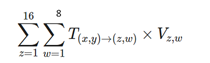

Once we have both the expected payoff of shooting and moving the ball using the following equation. Let's remember that in our model, g_x_y_t depends not only on values of location (x,y) but also on time-remaining-in-period t. m_x_y is the percent of the time a player chooses to move the ball in a given area (x,y)

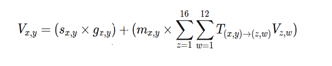

We assign a value to each location based on shooting threat and the potential to generate threat later in the possession. Therefore, the value of V_x_y is the Expected Threat (xT).

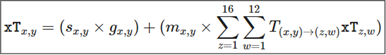

**Accounting for time remaining in half**

During our model, the average number of iterations was 10. An important distinction: since we are adding an extra feature to the model – time-remaining-in-period t – we need to run this process four times, to utilize the corresponding score-probability matrix to the equation. We utilize categorical variable to split the training set in four different bins for time-remaining-in-half and trained to model correspondingly. By fitting the model four times based on time remaining, we are obtaining m_x_y_t, s_x_y_t, and  g_x_y_t as well. 


**This is where dynamic programming  comes in handy**

For the equation to work, we need to know $xT$ of all possible locations (xT_z_w), and right now, that is not the case. To solve that, Singh proposes assigning xT = 0 to all cells (x,y) and evaluate the formula iteratively until convergence. During each iteration, assess the new xT for each zone using xT values from the previous iteration.

Each new iteration will utilize xT values from the previous iteration as xT_z_w. Therefore, the more iterations, the higher possible number of actions before the shoot-attempt we are considering. In other words, with 10 iterations, we are looking at up to 10 moves ahead of each scenario!

When we end our simulation for every bin, we obtain a 8x16 matrix with 128 values, each one representing the xT of a given cell. This matrix is simply called xT_t. on total we have four different matrices, oner for each bin of t.


**The wonder of Net Expected Threat**

As detailed during the solution segment, we developed an oxT and nxT. To generate to oxT we followed the same approach to generate the transition matrix T_x_y , but utilized failed move-actions (turnovers) instead of successful ones. We call it Turnover Transition Matrix L_x_y. We use L_x_y y to estimate the probability of turning over the puck at every possible cell in the rink and weighed the hypothetical xT that the other team would have in that scenario. By doing that, we obtained oxT. 

For sample size purposes, we created these matrices utilizing all bins of t.  To obtain hypothetical xT we used xT matrix from our original xT model. By obtaining the Hadamard product of  L_x_y, xT_t matrices and summing over all the entries the two matrices L_x_y, and xT_t, we obtain value oxT_x_y_t.

oxT_x_y_t =  sum(L_x_y ⊙ xT _t)

Then, to obtain the nxT for a given cell, we calculate the difference between the two values.

nxT_x_y_t = xT_x_y_t - oxT_x_y_t


We have four different values of nxT, depending on bin of t. 